C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

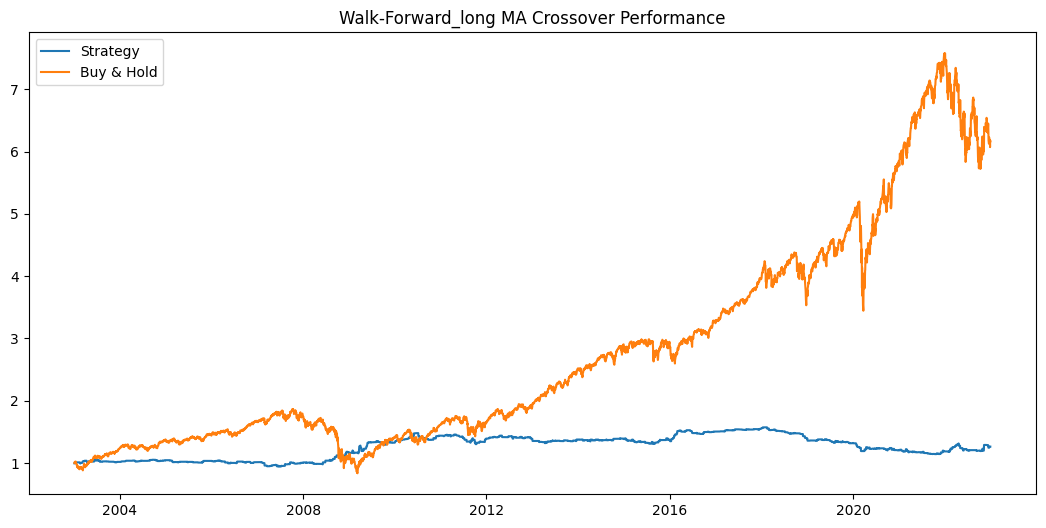

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

asset_list = [
    "SPY", "QQQ", "DIA",
    "EWJ", "EEM", "VGK",
    "TLT", "IEF", "BND",
    "GLD", "SLV", "USO",
    "EURUSD=X", "JPY=X", "AUDUSD=X",
    "BTC-USD", "ETH-USD"
]

def get_data(ticker):
    df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
    df.columns = df.columns.get_level_values(0)
    df = df[['Close', 'High', 'Low', 'Open']].dropna()
    return df

def apply_strategy(df):
    original_index = df.index.copy()
    df = df.reset_index(drop=True).copy()
    df['prev_2_high'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['prev_2_high']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['prev_2_high']) * df['Bull_FVG'] / df['Close']
    df['Bull_FVG_High'] = df['prev_2_high'] * df['Bull_FVG']
    df['Bull_FVG_Low'] = df['Low'] * df['Bull_FVG']

    df['prev_2_low'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['prev_2_low']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['prev_2_low']) * df['Bear_FVG'] / df['Close']
    df['Bear_FVG_High'] = df['High'] * df['Bear_FVG']
    df['Bear_FVG_Low'] = df['prev_2_low'] * df['Bear_FVG']
    
    df['signal'] = 0
    df['FVG_Strategy'] = 0
    active_bull_high = np.nan
    active_bull_low = np.nan
    active_bear_high = np.nan
    active_bear_low = np.nan

    for i in range(len(df)):
        row = df.iloc[i]

        if row['Bull_FVG'] == 1:
            active_bull_high = row['Bull_FVG_High']
            active_bull_low = row['Bull_FVG_Low']

        if row['Bear_FVG'] == 1:
            active_bear_high = row['Bear_FVG_High']
            active_bear_low = row['Bear_FVG_Low']

        if not np.isnan(active_bull_high):
            if (row['Low'] <= active_bull_high) and (row['High'] >= active_bull_high):
                df.iat[i, df.columns.get_loc('FVG_Strategy')] = 1
                active_bull_high = active_bull_low = np.nan

        if not np.isnan(active_bear_low):
            if (row['High'] >= active_bear_low) and (row['Low'] <= active_bear_low):
                df.iat[i, df.columns.get_loc('FVG_Strategy')] = -1
                active_bear_high = active_bear_low = np.nan


    df['signal'] = df['FVG_Strategy']
    df['signal'] = df['signal'].shift(1)            # trade next day
    df['signal'].fillna(0, inplace=True)

    # daily returns
    df['ret'] = df['Close'].pct_change().fillna(0)

    # strategy returns
    df['strategy_ret'] = df['signal'] * df['ret']

    result = df[['signal','strategy_ret', 'ret']].copy()
    result.index = original_index

    return result

def walk_forward(df, train_years=3, test_years=1):

    df = df.copy()
    results = []

    start = df.index.min()

    while True:
        train_start = start
        train_end = train_start + pd.DateOffset(years=train_years)
        test_end = train_end + pd.DateOffset(years=test_years)

        # break if test window exceeds data
        if test_end > df.index.max():
            break

        # slice windows
        train = df[(df.index >= train_start) & (df.index < train_end)]
        test = df[(df.index >= train_end) & (df.index < test_end)]


        # train + test combined for MA calculation
        combined = pd.concat([train, test])

        # apply strategy
        window_results = apply_strategy(combined)

        # keep only test window results
        window_results = window_results[window_results.index.isin(test.index)]
        # window_results.loc[test.index]

        results.append(window_results)

        # move forward
        start = start + pd.DateOffset(years=test_years)

    final = pd.concat(results)
    return final

ticker = "SPY"
df = get_data(ticker)

results = walk_forward(df, train_years=3, test_years=1)

# cumulative returns
strategy_curve = (1 + results['strategy_ret']).cumprod()
buyhold_curve = (1 + results['ret']).cumprod()

plt.figure(figsize=(13,6))
plt.plot(strategy_curve, label="Strategy")
plt.plot(buyhold_curve, label="Buy & Hold")
plt.title("Walk-Forward_long MA Crossover Performance")
plt.legend()
plt.show()



In [2]:
def run_strategy_on_asset(ticker):
    df = get_data(ticker)
    results = walk_forward(df)
    return results.dropna()

In [ ]:
from fredapi import Fred

fred_key ='(your fred api key)'

fred = Fred(api_key=fred_key)


In [4]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

SPY
CAGR: 0.0118
Max Drawdown: -0.2729
Sharpe Ratio: -75.6727
Sortino Ratio: -93.4049
Profit Factor: 1.1080
30 days Rolling Sharpe: -30.6386


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

QQQ
CAGR: 0.0165
Max Drawdown: -0.2964
Sharpe Ratio: -61.6889
Sortino Ratio: -80.7426
Profit Factor: 1.1254
30 days Rolling Sharpe: -49.1410


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

DIA
CAGR: 0.0048
Max Drawdown: -0.2810
Sharpe Ratio: -83.0571
Sortino Ratio: -96.7578
Profit Factor: 1.0578
30 days Rolling Sharpe: -45.5138


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

EWJ
CAGR: 0.0197
Max Drawdown: -0.2979
Sharpe Ratio: -64.2769
Sortino Ratio: -77.4601
Profit Factor: 1.1403
30 days Rolling Sharpe: -36.2351


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

EEM
CAGR: 0.0557
Max Drawdown: -0.1968
Sharpe Ratio: -44.8872
Sortino Ratio: -62.7673
Profit Factor: 1.2837
30 days Rolling Sharpe: -69.1087


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

VGK
CAGR: -0.0160
Max Drawdown: -0.4281
Sharpe Ratio: -56.5094
Sortino Ratio: -68.1551
Profit Factor: 0.9421
30 days Rolling Sharpe: -167.5934


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

TLT
CAGR: 0.0137
Max Drawdown: -0.2787
Sharpe Ratio: -92.8579
Sortino Ratio: -101.7461
Profit Factor: 1.1220
30 days Rolling Sharpe: -123.4206


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

IEF
CAGR: 0.0101
Max Drawdown: -0.0950
Sharpe Ratio: -182.4694
Sortino Ratio: -182.4694
Profit Factor: 1.1796
30 days Rolling Sharpe: -242.1758


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

BND
CAGR: -0.0007
Max Drawdown: -0.0730
Sharpe Ratio: -322.3711
Sortino Ratio: -322.3711
Profit Factor: 0.9827
30 days Rolling Sharpe: -230.1457


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

GLD
CAGR: 0.0211
Max Drawdown: -0.1690
Sharpe Ratio: -83.5942
Sortino Ratio: -92.0505
Profit Factor: 1.1810
30 days Rolling Sharpe: -97.1391


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

SLV
CAGR: 0.0578
Max Drawdown: -0.2429
Sharpe Ratio: -52.4956
Sortino Ratio: -70.1183
Profit Factor: 1.3501
30 days Rolling Sharpe: -103.6858


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

USO
CAGR: 0.0133
Max Drawdown: -0.3779
Sharpe Ratio: -39.9799
Sortino Ratio: -51.4950
Profit Factor: 1.0827
30 days Rolling Sharpe: -49.5644


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

EURUSD=X
CAGR: -0.0740
Max Drawdown: -0.7570
Sharpe Ratio: -139.2474
Sortino Ratio: -144.8937
Profit Factor: 0.3912
30 days Rolling Sharpe: -209.4767


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

JPY=X
CAGR: -0.0652
Max Drawdown: -0.7820
Sharpe Ratio: -128.8454
Sortino Ratio: -128.8454
Profit Factor: 0.4489
30 days Rolling Sharpe: -74.5235


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

AUDUSD=X
CAGR: -0.1005
Max Drawdown: -0.7852
Sharpe Ratio: -118.3713
Sortino Ratio: -121.8020
Profit Factor: 0.3403
30 days Rolling Sharpe: -117.7554


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

BTC-USD
CAGR: -0.1252
Max Drawdown: -0.5700
Sharpe Ratio: -28.7750
Sortino Ratio: -35.2247
Profit Factor: 0.7968
30 days Rolling Sharpe: -225.9592


[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)


ETH-USD
CAGR: 0.0832
Max Drawdown: -0.2998
Sharpe Ratio: -23.4913
Sortino Ratio: -33.4405
Profit Factor: 1.2152
30 days Rolling Sharpe: -60.4419


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [5]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

SPY
CAGR: 0.0118
Max Drawdown: -0.2729
Sharpe Ratio: -75.6727
Sortino Ratio: -93.4049
Profit Factor: 1.1080
30 days Rolling Sharpe: -30.6386


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

QQQ
CAGR: 0.0165
Max Drawdown: -0.2964
Sharpe Ratio: -61.6889
Sortino Ratio: -80.7426
Profit Factor: 1.1254
30 days Rolling Sharpe: -49.1410


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

DIA
CAGR: 0.0048
Max Drawdown: -0.2810
Sharpe Ratio: -83.0571
Sortino Ratio: -96.7578
Profit Factor: 1.0578
30 days Rolling Sharpe: -45.5138


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

EWJ
CAGR: 0.0197
Max Drawdown: -0.2979
Sharpe Ratio: -64.2769
Sortino Ratio: -77.4601
Profit Factor: 1.1403
30 days Rolling Sharpe: -36.2351



C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

EEM
CAGR: 0.0557
Max Drawdown: -0.1968
Sharpe Ratio: -44.8872
Sortino Ratio: -62.7673
Profit Factor: 1.2837
30 days Rolling Sharpe: -69.1087


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

VGK
CAGR: -0.0160
Max Drawdown: -0.4281
Sharpe Ratio: -56.5094
Sortino Ratio: -68.1551
Profit Factor: 0.9421
30 days Rolling Sharpe: -167.5934



C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

TLT
CAGR: 0.0137
Max Drawdown: -0.2787
Sharpe Ratio: -92.8579
Sortino Ratio: -101.7461
Profit Factor: 1.1220
30 days Rolling Sharpe: -123.4206



C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

IEF
CAGR: 0.0101
Max Drawdown: -0.0950
Sharpe Ratio: -182.4694
Sortino Ratio: -182.4694
Profit Factor: 1.1796
30 days Rolling Sharpe: -242.1758


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

BND
CAGR: -0.0007
Max Drawdown: -0.0730
Sharpe Ratio: -322.3711
Sortino Ratio: -322.3711
Profit Factor: 0.9827
30 days Rolling Sharpe: -230.1457


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

GLD
CAGR: 0.0211
Max Drawdown: -0.1690
Sharpe Ratio: -83.5942
Sortino Ratio: -92.0505
Profit Factor: 1.1810
30 days Rolling Sharpe: -97.1391



C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

SLV
CAGR: 0.0578
Max Drawdown: -0.2429
Sharpe Ratio: -52.4956
Sortino Ratio: -70.1183
Profit Factor: 1.3501
30 days Rolling Sharpe: -103.6858


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

USO
CAGR: 0.0133
Max Drawdown: -0.3779
Sharpe Ratio: -39.9799
Sortino Ratio: -51.4950
Profit Factor: 1.0827
30 days Rolling Sharpe: -49.5644


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

EURUSD=X
CAGR: -0.0740
Max Drawdown: -0.7570
Sharpe Ratio: -139.2474
Sortino Ratio: -144.8937
Profit Factor: 0.3912
30 days Rolling Sharpe: -209.4767


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

JPY=X
CAGR: -0.0652
Max Drawdown: -0.7820
Sharpe Ratio: -128.8454
Sortino Ratio: -128.8454
Profit Factor: 0.4489
30 days Rolling Sharpe: -74.5235


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

AUDUSD=X
CAGR: -0.1005
Max Drawdown: -0.7852
Sharpe Ratio: -118.3713
Sortino Ratio: -121.8020
Profit Factor: 0.3403
30 days Rolling Sharpe: -117.7554


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

BTC-USD
CAGR: -0.1252
Max Drawdown: -0.5700
Sharpe Ratio: -28.7750
Sortino Ratio: -35.2247
Profit Factor: 0.7968
30 days Rolling Sharpe: -225.9592


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

ETH-USD
CAGR: 0.0832
Max Drawdown: -0.2998
Sharpe Ratio: -23.4913
Sortino Ratio: -33.4405
Profit Factor: 1.2152
30 days Rolling Sharpe: -60.4419


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)


In [6]:
from scipy.stats import ttest_rel, wilcoxon, binomtest
import numpy as np

def statistical_tests(res):
    strat = res['strategy_ret']
    bench = res['ret']
    diff = strat - bench
    
    tests = {}

    # Paired t-test
    t_stat, p_t = ttest_rel(strat, bench)
    tests['paired_t_p'] = p_t

    # Wilcoxon test (non-parametric)
    w_stat, p_w = wilcoxon(strat, bench)
    tests['wilcoxon_p'] = p_w

    # Directional accuracy
    future = res['ret'].shift(-1)
    correct = ((res['signal']==1)&(future>0)) | ((res['signal']==0)&(future<0))
    accuracy = correct.mean()
    tests['accuracy'] = accuracy

    # Binomial test for accuracy vs 0.5
    tests['accuracy_binom_p'] = binomtest(
        correct.sum(), n=len(correct), p=0.5
    )

    return tests

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(res):
    df = res[['ret', 'signal']].dropna()
    # Does signal cause returns?
    g1 = grangercausalitytests(df[['ret','signal']], maxlag=5, verbose=False)
    # Does return cause signal? (control test)
    g2 = grangercausalitytests(df[['signal','ret']], maxlag=5, verbose=False)
    return g1, g2

In [8]:
def random_permutation_test(res, n=5000):
    real_perf = (1 + res['strategy_ret']).prod()

    random_perf = []
    for _ in range(n):
        shuffled = res['ret'].sample(frac=1, replace=False).values
        shuffled_strat = res['signal'].values * shuffled
        random_perf.append((1 + shuffled_strat).prod())

    random_perf = np.array(random_perf)
    p_value = np.mean(random_perf > real_perf)

    return real_perf, random_perf.mean(), p_value

In [9]:
granger_test_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    g1, g2 = granger_test(results)
    granger_test_results[ticker] = {
        'Does signal cause returns?' : g1,
        'Does return cause signal? (control test)' : g2
    }

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [10]:
granger_test_results

{'SPY': {'Does signal cause returns?': {np.int64(1): ({'ssr_ftest': (np.float64(0.16045554441110724),
      np.float64(0.6887544663957677),
      np.float64(5030.0),
      np.int64(1)),
     'ssr_chi2test': (np.float64(0.16055124354296277),
      np.float64(0.6886495066733495),
      np.int64(1)),
     'lrtest': (np.float64(0.16054868283390533),
      np.float64(0.6886518595665612),
      np.int64(1)),
     'params_ftest': (np.float64(0.16045554441016419),
      np.float64(0.6887544663967942),
      np.float64(5030.0),
      1.0)},
     array([[0., 1., 0.]])]),
   np.int64(2): ({'ssr_ftest': (np.float64(0.7968837309198803),
      np.float64(0.45078830721179863),
      np.float64(5027.0),
      np.int64(2)),
     'ssr_chi2test': (np.float64(1.5953526691819526),
      np.float64(0.45037426828664706),
      np.int64(2)),
     'lrtest': (np.float64(1.5950998261469067),
      np.float64(0.4504312088842798),
      np.int64(2)),
     'params_ftest': (np.float64(0.7968837309192489),
      np.f

In [11]:
final_results = {}

for ticker in asset_list:
    res = run_strategy_on_asset(ticker)
    tests = statistical_tests(res)
    g1, g2 = granger_test(res)
    perm_real, perm_mean, perm_p = random_permutation_test(res)

    final_results[ticker] = {
        **tests,
        'shuffle_mean_perf': perm_mean,
        'shuffle_p_value': perm_p,
    }


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

In [12]:
final_results

{'SPY': {'paired_t_p': np.float64(0.03455937642628363),
  'wilcoxon_p': np.float64(2.3948614201899304e-08),
  'accuracy': np.float64(0.4245133094954311),
  'accuracy_binom_p': BinomTestResult(k=2137, n=5034, alternative='two-sided', statistic=0.4245133094954311, pvalue=8.395393325249253e-27),
  'shuffle_mean_perf': np.float64(1.0339475680450214),
  'shuffle_p_value': np.float64(0.2156)},
 'QQQ': {'paired_t_p': np.float64(0.013922504511924736),
  'wilcoxon_p': np.float64(4.647646792954566e-08),
  'accuracy': np.float64(0.4223281684545093),
  'accuracy_binom_p': BinomTestResult(k=2126, n=5034, alternative='two-sided', statistic=0.4223281684545093, pvalue=2.7467522131344155e-28),
  'shuffle_mean_perf': np.float64(1.061783287143373),
  'shuffle_p_value': np.float64(0.1756)},
 'DIA': {'paired_t_p': np.float64(0.020660331762749555),
  'wilcoxon_p': np.float64(1.2623372777732895e-08),
  'accuracy': np.float64(0.42709574890742946),
  'accuracy_binom_p': BinomTestResult(k=2150, n=5034, alternat

In [13]:
def seperate_by_regimes(results, regimes):
    common_dates = results.index.intersection(regimes.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and regimes!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    aligned_regimes = regimes.loc[common_dates]
    
    # Separate
    low_vol_dates = aligned_regimes[aligned_regimes == 0].index
    high_vol_dates = aligned_regimes[aligned_regimes == 1].index
    
    low_vol = results.loc[low_vol_dates].copy()
    high_vol = results.loc[high_vol_dates].copy()
    
    print(f"\nFound {len(low_vol)} low volatility days")
    print(f"Found {len(high_vol)} high volatility days")
    print(f"Total: {len(low_vol) + len(high_vol)} days")
    
    return low_vol, high_vol

In [14]:
def analyze_by_regime(low_vol, high_vol):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(low_vol) + len(high_vol)
    print(f"\nLow Volatility Days:  {len(low_vol):>6} ({len(low_vol)/total_days*100:>5.1f}%)")
    print(f"High Volatility Days: {len(high_vol):>6} ({len(high_vol)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Low Vol':>15} {'High Vol':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(low_vol) > 0:
        low_strat_ret = low_vol['strategy_ret'].mean() * 252 * 100
        low_strat_vol = low_vol['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = low_vol['strategy_ret'].mean() / low_vol['strategy_ret'].std() * np.sqrt(252) if low_vol['strategy_ret'].std() > 0 else 0
        low_bh_ret = low_vol['ret'].mean() * 252 * 100
        low_bh_vol = low_vol['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = low_vol['ret'].mean() / low_vol['ret'].std() * np.sqrt(252) if low_vol['ret'].std() > 0 else 0
        low_win = (low_vol['strategy_ret'] > 0).sum() / len(low_vol) * 100
        low_strat_total = (1 + low_vol['strategy_ret']).prod() - 1
        low_bh_total = (1 + low_vol['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(high_vol) > 0:
        high_strat_ret = high_vol['strategy_ret'].mean() * 252 * 100
        high_strat_vol = high_vol['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = high_vol['strategy_ret'].mean() / high_vol['strategy_ret'].std() * np.sqrt(252) if high_vol['strategy_ret'].std() > 0 else 0
        high_bh_ret = high_vol['ret'].mean() * 252 * 100
        high_bh_vol = high_vol['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = high_vol['ret'].mean() / high_vol['ret'].std() * np.sqrt(252) if high_vol['ret'].std() > 0 else 0
        high_win = (high_vol['strategy_ret'] > 0).sum() / len(high_vol) * 100
        high_strat_total = (1 + high_vol['strategy_ret']).prod() - 1
        high_bh_total = (1 + high_vol['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

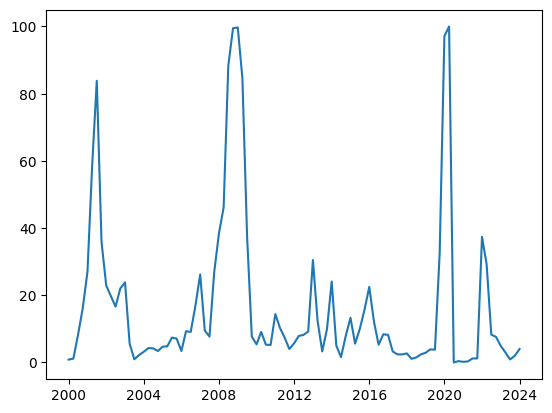

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\3603618892.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["recession"].iloc[i] = 1
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\3603618892.py:24: SettingWithCopyWarning: 
A valu

In [15]:
recession_indicator_index = fred.get_series(series_id='JHGDPBRINDX', observation_start = '2000-01-01', observation_end='2024-01-01')
plt.figure()
plt.plot(recession_indicator_index)
plt.show()

recession_indicator_index = recession_indicator_index.copy()
recession_indicator_index = recession_indicator_index.to_frame(name='index')
recession_indicator_index.index = pd.to_datetime(recession_indicator_index.index)
recession_indicator_index = recession_indicator_index.resample('D').ffill()

def label_recessions(df):
    df = df.copy()
    df["recession"] = 0
    
    in_recession = False
    
    for i in range(len(df)):
        value = df["index"].iloc[i]
        
        if not in_recession:
            # recession starts
            if value > 67:
                in_recession = True
                df["recession"].iloc[i] = 1
        else:
            # currently in recession
            df["recession"].iloc[i] = 1
            
            # recession ends
            if value < 33:
                in_recession = False
    
    return df

fred_rec = label_recessions(recession_indicator_index)

In [16]:
fred_rec

,index,recession
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0
2023-12-31,2.0000,0


In [17]:
fred_rec = fred_rec.reset_index()
fred_rec.columns = ['Date', 'index', 'recession']

# Make sure Date is datetime
fred_rec['Date'] = pd.to_datetime(fred_rec['Date'])
fred_rec.set_index('Date')

,index,recession
Date,,
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0


In [18]:
def seperate_by_recession(results, recession):
    common_dates = results.index.intersection(recession.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and recession!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    recession_regimes = recession.loc[common_dates]
    
    # Separate
    non_recession_dates = recession_regimes[recession_regimes == 0].index
    recession_dates = recession_regimes[recession_regimes == 1].index
    
    non_recession_dates = results.loc[non_recession_dates].copy()
    recession_dates = results.loc[recession_dates].copy()
    
    print(f"\nFound {len(non_recession_dates)} non recession days")
    print(f"Found {len(recession_dates)} recession days")
    print(f"Total: {len(non_recession_dates) + len(recession_dates)} days")
    
    return recession_dates, non_recession_dates

In [19]:
def analyze_by_regime(recession_dates, non_recession_dates):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(non_recession_dates) + len(recession_dates)
    print(f"\nNon-Recession Days:  {len(non_recession_dates):>6} ({len(non_recession_dates)/total_days*100:>5.1f}%)")
    print(f"Recession Days: {len(recession_dates):>6} ({len(recession_dates)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Non-Recession':>15} {'Recession':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(non_recession_dates) > 0:
        low_strat_ret = non_recession_dates['strategy_ret'].mean() * 252 * 100
        low_strat_vol = non_recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = non_recession_dates['strategy_ret'].mean() / non_recession_dates['strategy_ret'].std() * np.sqrt(252) if non_recession_dates['strategy_ret'].std() > 0 else 0
        low_bh_ret = non_recession_dates['ret'].mean() * 252 * 100
        low_bh_vol = non_recession_dates['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = non_recession_dates['ret'].mean() / non_recession_dates['ret'].std() * np.sqrt(252) if non_recession_dates['ret'].std() > 0 else 0
        low_win = (non_recession_dates['strategy_ret'] > 0).sum() / len(non_recession_dates) * 100
        low_strat_total = (1 + non_recession_dates['strategy_ret']).prod() - 1
        low_bh_total = (1 + non_recession_dates['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(recession_dates) > 0:
        high_strat_ret = recession_dates['strategy_ret'].mean() * 252 * 100
        high_strat_vol = recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = recession_dates['strategy_ret'].mean() / recession_dates['strategy_ret'].std() * np.sqrt(252) if recession_dates['strategy_ret'].std() > 0 else 0
        high_bh_ret = recession_dates['ret'].mean() * 252 * 100
        high_bh_vol = recession_dates['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = recession_dates['ret'].mean() / recession_dates['ret'].std() * np.sqrt(252) if recession_dates['ret'].std() > 0 else 0
        high_win = (recession_dates['strategy_ret'] > 0).sum() / len(recession_dates) * 100
        high_strat_total = (1 + recession_dates['strategy_ret']).prod() - 1
        high_bh_total = (1 + recession_dates['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

    

In [20]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

models = {}
all_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    all_results[ticker] = results
    market_ret = results['ret']
    # Fit on in-sample window
    model = MarkovRegression(
        market_ret,
        k_regimes=2,
        trend="c",
        switching_variance=True
    )

    models[ticker] = model.fit()
    


C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\18020093.py:67: FutureWarning: A value i

In [21]:
all_results['SPY']

Price,signal,strategy_ret,ret
Date,,,
2003-01-03,-1.0,-0.003075,0.003075
2003-01-06,0.0,0.000000,0.017625
2003-01-07,0.0,-0.000000,-0.002474
2003-01-08,0.0,-0.000000,-0.014450
2003-01-09,1.0,0.015537,0.015537
...,...,...,...
2022-12-23,0.0,0.000000,0.005752
2022-12-27,0.0,-0.000000,-0.003944
2022-12-28,0.0,-0.000000,-0.012428


In [22]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Separate and analyze
    results = all_results[ticker]
    recession_dates, non_recession_dates = seperate_by_recession(results, fred_rec)
    analyze_by_regime(recession_dates, non_recession_dates)


ASSET: SPY

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:       0 (  0.0%)
Recession Days:   5034 (100.0%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                       0.00%          26.53%
Total Return (Buy&Hold)                       0.00%         516.35%
Ann. Return (Strategy)                        0.00%           1.41%
Ann. Return (Buy&Hold)                        0.00%          10.93%
Ann. Volatility (Strategy)                    0.00%           6.88%
Ann. Volatility (Buy&Hold)                    0.00%          19.11%
Sharpe Ratio (Strategy)                        0.00            0.21
Sharpe Ratio (Buy&Hold)                        0.00            0.57
Win Rate (Strategy)                           0.00%           6.75%

ASSET: QQQ

REGIME ANALYSIS - WALK-FORWARD RESULTS

No

In [23]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Get regime from that asset's model
    regime = models[ticker].smoothed_marginal_probabilities.idxmax(axis=1)
    
    # Separate and analyze
    results = all_results[ticker]
    low_vol, high_vol = seperate_by_regimes(results, regime)
    analyze_by_regime(low_vol, high_vol)


ASSET: SPY

Found 3671 low volatility days
Found 1363 high volatility days
Total: 5034 days

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:    1363 ( 27.1%)
Recession Days:   3671 ( 72.9%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                      57.58%         -19.70%
Total Return (Buy&Hold)                     -77.60%        2651.84%
Ann. Return (Strategy)                        9.07%          -1.43%
Ann. Return (Buy&Hold)                      -22.44%          23.33%
Ann. Volatility (Strategy)                   11.49%           3.97%
Ann. Volatility (Buy&Hold)                   32.27%          10.59%
Sharpe Ratio (Strategy)                        0.79           -0.36
Sharpe Ratio (Buy&Hold)                       -0.70            2.20
Win Rate (Strategy)                       

In [24]:
import statsmodels.api as sm

def newey_west_alpha_test(res):
    y = res['strategy_ret'] - res['ret']      # strategy excess over market
    X = np.ones(len(y))                       # constant only
    model = sm.OLS(y, X)
    nw = model.fit(cov_type='HAC', cov_kwds={'maxlags':5})
    return nw.tvalues[0], nw.pvalues[0]

for ticker in asset_list:
    results = all_results[ticker]
    t_values, p_values = newey_west_alpha_test(results)
    print(f"{ticker} t_values = {t_values}")
    print(f"{ticker} p_values = {p_values}")
    print("=" * 70)

SPY t_values = -2.3682223395755613
SPY p_values = 0.017873790914673327
QQQ t_values = -2.6397374822230057
QQQ p_values = 0.008297026934095347
DIA t_values = -2.6029049917353855
DIA p_values = 0.009243756610703539
EWJ t_values = -0.9811166432996536
EWJ p_values = 0.326535223921938
EEM t_values = -0.17115951084336634
EEM p_values = 0.8640983432995477
VGK t_values = -1.1296196048674523
VGK p_values = 0.2586365464473763
TLT t_values = -0.86235501869176
TLT p_values = 0.3884921851716031
IEF t_values = -1.4088339966046464
IEF p_values = 0.15888425999869826
BND t_values = -1.9483185675633752
BND p_values = 0.0513768568014048
GLD t_values = -1.0018937206508924
GLD p_values = 0.31639492569659455
SLV t_values = -0.2909603610683509
SLV p_values = 0.7710816358114673
USO t_values = 0.40180868112602036
USO p_values = 0.6878248327778873
EURUSD=X t_values = -2.9045570792407878
EURUSD=X p_values = 0.003677731375459756
JPY=X t_values = -3.281476389068972
JPY=X p_values = 0.0010326516970445836
AUDUSD=X t

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    return {
        'adf_p': adfuller(series.dropna())[1],
        'kpss_p': kpss(series.dropna(), nlags='auto')[1]
    }

for ticker in asset_list:
    results = all_results[ticker]
    adf_p, kpps_p = newey_west_alpha_test(results)
    print(f"{ticker} adf p_value = {adf_p}")
    print(f"{ticker} kpps p_value = {kpps_p}")
    print("=" * 70)

SPY adf p_value = -2.3682223395755613
SPY kpps p_value = 0.017873790914673327
QQQ adf p_value = -2.6397374822230057
QQQ kpps p_value = 0.008297026934095347
DIA adf p_value = -2.6029049917353855
DIA kpps p_value = 0.009243756610703539
EWJ adf p_value = -0.9811166432996536
EWJ kpps p_value = 0.326535223921938
EEM adf p_value = -0.17115951084336634
EEM kpps p_value = 0.8640983432995477
VGK adf p_value = -1.1296196048674523
VGK kpps p_value = 0.2586365464473763
TLT adf p_value = -0.86235501869176
TLT kpps p_value = 0.3884921851716031
IEF adf p_value = -1.4088339966046464
IEF kpps p_value = 0.15888425999869826
BND adf p_value = -1.9483185675633752
BND kpps p_value = 0.0513768568014048
GLD adf p_value = -1.0018937206508924
GLD kpps p_value = 0.31639492569659455
SLV adf p_value = -0.2909603610683509
SLV kpps p_value = 0.7710816358114673
USO adf p_value = 0.40180868112602036
USO kpps p_value = 0.6878248327778873
EURUSD=X adf p_value = -2.9045570792407878
EURUSD=X kpps p_value = 0.0036777313754

C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_19896\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.

In [26]:
import numpy as np
from scipy.stats import norm

def ledoit_wolf_sharpe_test(r1, r2):
    n = len(r1)
    mean1, mean2 = np.mean(r1), np.mean(r2)
    std1, std2  = np.std(r1, ddof=1), np.std(r2, ddof=1)

    sharpe1, sharpe2 = mean1/std1, mean2/std2
    diff = sharpe1 - sharpe2

    # LW correction components
    term1 = (mean1**2 / (2 * std1**4)) * np.var((r1 - mean1)**2)
    term2 = (mean2**2 / (2 * std2**4)) * np.var((r2 - mean2)**2)
    var_diff = term1 + term2

    z = diff / np.sqrt(var_diff / n)
    p = 1 - norm.cdf(z)  # one-sided test: is Sharpe1 > Sharpe2?

    return sharpe1, sharpe2, diff, z, p

for ticker in asset_list:
    results = all_results[ticker]
    s1, s2, diff, z, p = ledoit_wolf_sharpe_test(results['strategy_ret'], results['ret'])
    print(f'p value for {ticker} = {p}')

p value for SPY = 1.0
p value for QQQ = 1.0
p value for DIA = 1.0
p value for EWJ = 1.0
p value for EEM = 0.0
p value for VGK = 1.0
p value for TLT = 1.0
p value for IEF = 1.0
p value for BND = 1.0
p value for GLD = 1.0
p value for SLV = 0.0
p value for USO = 0.0
p value for EURUSD=X = 1.0
p value for JPY=X = 1.0
p value for AUDUSD=X = 1.0
p value for BTC-USD = 1.0
p value for ETH-USD = 1.0


In [27]:
import numpy as np

def bootstrap_significance(strategy_returns, n_boot=5000):
    actual_mean = np.mean(strategy_returns)

    boot_means = []
    for _ in range(n_boot):
        random_sign = np.random.choice([-1, 1], size=len(strategy_returns))
        boot_means.append(np.mean(strategy_returns * random_sign))

    p_value = np.mean(np.array(boot_means) >= actual_mean)
    return actual_mean, np.mean(boot_means), p_value

for ticker in asset_list:
    results = all_results[ticker]
    actual_mean, boot_mean, p_value = bootstrap_significance(results['strategy_ret'])
    print(f'{ticker} p_value = {p_value}')


SPY p_value = 0.174
QQQ p_value = 0.1408
DIA p_value = 0.315
EWJ p_value = 0.1104
EEM p_value = 0.0138
VGK p_value = 0.695
TLT p_value = 0.1216
IEF p_value = 0.0622


BND p_value = 0.5608
GLD p_value = 0.069
SLV p_value = 0.0074
USO p_value = 0.2556
EURUSD=X p_value = 1.0
JPY=X p_value = 1.0
AUDUSD=X p_value = 1.0
BTC-USD p_value = 0.887
ETH-USD p_value = 0.227
